In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
print(sys.executable)
%pip install seaborn

C:\Users\tymig\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\tymig\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import seaborn as sns

In [4]:
refactor_commits = pd.read_csv('TruePositiveCommits.csv')
cumulative_commits = pd.read_csv('results_clean_unquoted.csv')

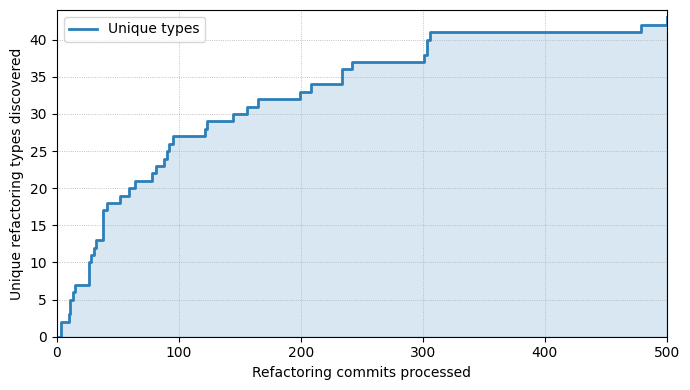

In [ ]:
##### THIS IS JUST BE ONE PASS NO SHUFFLING -- NOT FOR THE PAPER NECESSARILY #####
# Build a lookup of refactor labels per SHA
# categorized refactoring columns (1-6) contain the refactoring labels
refactor_cols = [c for c in refactor_commits.columns if c.lower().startswith("categorized refactoring")]
refactor_lookup = refactor_commits[["SHA", *refactor_cols]]

seen_labels = set()
x_vals, y_vals = [], []

for idx, sha in enumerate(cumulative_commits["sha"], start=1):
    matching = refactor_lookup[refactor_lookup["SHA"] == sha]
    if not matching.empty:
        for val in matching[refactor_cols].values.ravel():
            if pd.notna(val) and str(val).strip():
                label = str(val).strip()
                if label:
                    seen_labels.add(label.lower())
    x_vals.append(idx)               # commits processed (index)
    y_vals.append(len(seen_labels))  # unique refactoring types seen so far

fig, ax = plt.subplots(figsize=(7, 4))
ax.step(x_vals, y_vals, where="post", color="#2c7fb8", lw=2, label="Unique types")
ax.fill_between(x_vals, y_vals, step="post", color="#2c7fb8", alpha=0.18)
ax.set_xlabel("Refactoring commits processed")
ax.set_ylabel("Unique refactoring types discovered")
ax.set_xlim(left=0, right=max(x_vals))
ax.set_ylim(bottom=0, top=max(y_vals) + 1)
ax.grid(True, linestyle=":", linewidth=0.6)
ax.legend()
plt.tight_layout()
plt.show()


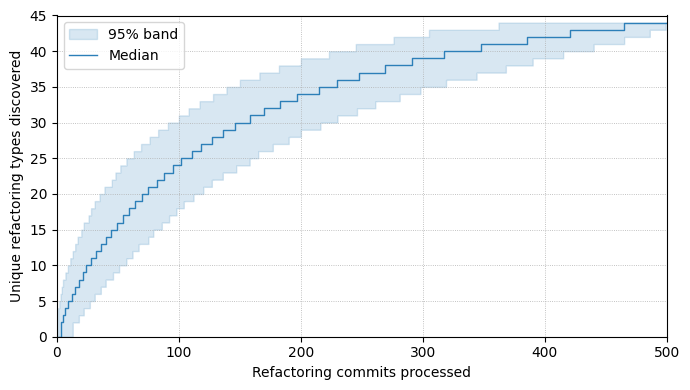

In [ ]:
# Map each SHA to its set of labels (lowercased)
labels_by_sha = (
    refactor_lookup
    .assign(**{c: refactor_lookup[c].astype(str).str.strip().str.lower()
               for c in refactor_cols})
    .melt(id_vars="SHA", value_vars=refactor_cols, value_name="label")
    .dropna()
    .query("label != ''")
    .groupby("SHA")["label"]
    .apply(set)
    .to_dict()
)

num_runs = 2000  # increase for more shuffled iterations
n = len(cumulative_commits)
trajectories = np.zeros((num_runs, n), dtype=int)

# Simulate random orderings and track unique refactoring types discovered
for r in range(num_runs):
    seen = set()
    order = cumulative_commits.sample(frac=1, replace=False, random_state=r)["sha"].to_list()
    for i, sha in enumerate(order):
        for label in labels_by_sha.get(sha, ()):
            seen.add(label)
        trajectories[r, i] = len(seen)

x_vals = np.arange(1, n + 1)
median = np.percentile(trajectories, 50, axis=0)
lower = np.percentile(trajectories, 2.5, axis=0)
upper = np.percentile(trajectories, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(7, 4))
ax.fill_between(x_vals, lower, upper, step="post", color="#2c7fb8", alpha=0.18, label="95% band")
ax.step(x_vals, median, where="post", color="#2c7fb8", lw=1, label="Median")
ax.set_xlabel("Refactoring commits processed")
ax.set_ylabel("Unique refactoring types discovered")
ax.set_xlim(left=0, right=max(x_vals))
ax.set_ylim(bottom=0, top=upper.max() + 1)
ax.grid(True, linestyle=":", linewidth=0.6)
ax.legend()
plt.tight_layout()

out_path = "unique_refactoring_discovery.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")

plt.show()


In [ ]:
### This counts the number of occurrences of each refactoring type across every refactor column ###
### This is why nan occurs 697 times -- because that is how many refactor column cells are empty ###
# Collect labels from all Categorized Refactoring columns (case-insensitive)
labels = (
    refactor_commits[refactor_cols]
    .apply(lambda c: c.astype(str).str.strip().str.lower())
    .melt(value_name="label")["label"]
)

labels = labels[labels.notna() & (labels != "")]
counts = labels.value_counts().sort_values(ascending=False)

# Generate the counts and proportions of each refactoring type
summary = pd.DataFrame({
    "count": counts,
    "proportion": counts / counts.sum()
})

display(summary)

,count,proportion
label,,
nan,697,0.712679
message handling,39,0.039877
checkpointer,25,0.025562
altered state schema (messages),24,0.024540
sub-agents,18,0.018405
asynchronous invocation,10,0.010225
model arguments,10,0.010225
caching,9,0.009202
graph modularization,9,0.009202


In [ ]:
### Alternative: Count how many rows mention each refactoring type (regardless of column)
### This works assuming that if a row mentions the refactoring type in any column then it contains that refactoring
### I considered these results more meaningful for the paper

# Normalize labels to lowercase/stripped
norm = refactor_commits[refactor_cols].apply(lambda c: c.astype(str).str.strip().str.lower())

# Collect unique labels per row (avoid double-counting same label in a row)
row_labels = norm.apply(lambda row: {v for v in row if v and v != "nan"}, axis=1)

# Explode to one label per row, then count row occurrences
label_rows = row_labels.apply(list).explode()
counts = label_rows.value_counts().sort_values(ascending=False)

summary = pd.DataFrame({
    "row_count": counts,
    "row_proportion": counts / len(refactor_commits)  # proportion of observations with that label
})

display(summary)


,row_count,row_proportion
message handling,39,0.239264
checkpointer,25,0.153374
altered state schema (messages),24,0.147239
sub-agents,18,0.110429
asynchronous invocation,10,0.061350
model arguments,10,0.061350
caching,9,0.055215
graph modularization,9,0.055215
type safety,8,0.049080
graph restructure,8,0.049080


In [ ]:
import itertools
from collections import Counter

### Build co-occurrence matrix of refactoring types ###
### This is used for a heatmap in the paper ###
### I thought this would be the most interesting way to show relationships between refactoring types ###

# Normalize labels per row (lowercase, strip); keep uniques per row
norm = refactor_commits[refactor_cols].apply(lambda c: c.astype(str).str.strip().str.lower())
row_sets = norm.apply(lambda row: {v for v in row if v and v != "nan"}, axis=1)

pair_counts = Counter()
for labels in row_sets:
    for a, b in itertools.combinations(sorted(labels), 2):
        pair_counts[(a, b)] += 1

# Build matrix
pairs_df = pd.DataFrame(
    [(a, b, cnt) for (a, b), cnt in pair_counts.items()],
    columns=["label_a", "label_b", "count"]
)
matrix = pairs_df.pivot(index="label_a", columns="label_b", values="count").fillna(0)
# Symmetrize (optional)
matrix = matrix.add(matrix.T, fill_value=0)

# Proportions (by rows)
matrix_prop = matrix / len(refactor_commits)

display(matrix.sort_index().sort_index(axis=1))       # counts
display(matrix_prop.sort_index().sort_index(axis=1))  # proportions

,add conversational memory,additional kwargs,agent planning,altered agent architecture,altered state schema (messages),asynchronous invocation,caching,changed system prompt,chatprompttemplate,checkpointer,...,recursion limit,runnable sequence,streaming,structuredtool,sub-agents,token tracking,tool decorator,tool naming conventions,tool refactor,type safety
add conversational memory,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
additional kwargs,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
agent planning,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
altered agent architecture,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
altered state schema (messages),0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,1.0,3.0,...,0.0,0.0,1.0,2.0,6.0,0.0,2.0,0.0,1.0,1.0
asynchronous invocation,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
caching,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
changed system prompt,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
chatprompttemplate,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
checkpointer,0.0,1.0,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,...,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0


,add conversational memory,additional kwargs,agent planning,altered agent architecture,altered state schema (messages),asynchronous invocation,caching,changed system prompt,chatprompttemplate,checkpointer,...,recursion limit,runnable sequence,streaming,structuredtool,sub-agents,token tracking,tool decorator,tool naming conventions,tool refactor,type safety
add conversational memory,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
additional kwargs,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.006135,...,0.000000,0.000000,0.006135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
agent planning,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.006135,0.000000,0.000000,0.000000,0.006135,0.000000,0.000000,0.000000,0.000000,0.000000
altered agent architecture,NaN,NaN,NaN,NaN,0.006135,0.000000,NaN,0.000000,0.006135,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
altered state schema (messages),0.000000,0.000000,0.000000,0.006135,0.000000,0.018405,0.000000,0.006135,0.006135,0.018405,...,0.000000,0.000000,0.006135,0.012270,0.036810,0.000000,0.012270,0.000000,0.006135,0.006135
asynchronous invocation,0.000000,0.000000,0.000000,0.000000,0.018405,0.000000,0.000000,0.000000,0.000000,0.018405,...,0.000000,0.000000,0.006135,0.000000,0.000000,0.006135,0.000000,0.000000,0.000000,0.018405
caching,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.006135,0.000000,0.000000,0.000000,0.000000,0.000000
changed system prompt,0.000000,0.000000,0.000000,0.000000,0.006135,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006135
chatprompttemplate,0.000000,0.000000,0.000000,0.006135,0.006135,0.000000,0.000000,0.000000,0.000000,0.006135,...,0.000000,0.000000,0.000000,0.000000,0.006135,0.000000,0.006135,0.000000,0.000000,0.000000
checkpointer,0.000000,0.006135,0.000000,0.000000,0.018405,0.018405,0.000000,0.000000,0.006135,0.000000,...,0.000000,0.000000,0.018405,0.006135,0.000000,0.006135,0.000000,0.000000,0.012270,0.006135


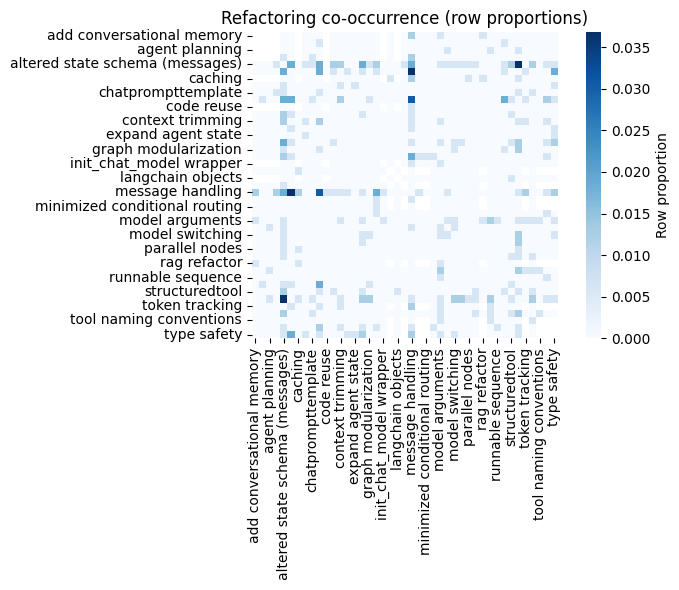

In [ ]:
### Heatmap showing cooccurrence of EVERY refactoring type in the dataset ###
### This is messy and includes some refactors that we are not including in the paper ###

# import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_prop, cmap="Blues", square=True, cbar_kws={"label": "Row proportion"})
plt.title("Refactoring co-occurrence (row proportions)")
plt.tight_layout()
plt.show()

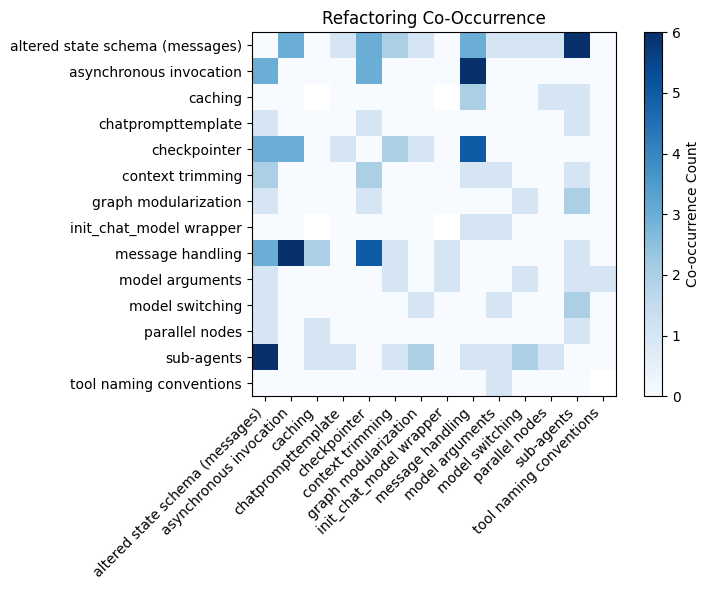

In [ ]:
### This is the visual seen in the paper ###
### Heatmap showing cooccurrence of SELECTED refactoring types in the dataset ###
### These are the refactoring types we are including in the paper (as of our last meeting) ###

subset = ["altered state schema (messages)", "caching", "chatprompttemplate", "context trimming", 
"graph modularization", "init_chat_model wrapper", "model arguments", "model switching",
"parallel nodes", "structured tool", "tool naming conventions", "sub-agents", "asynchronous invocation",
"message handling", "checkpointer"]

sub = matrix.loc[matrix.index.intersection(subset), matrix.columns.intersection(subset)]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(sub.values, cmap="Blues")
ax.set_xticks(range(len(sub.columns)))
ax.set_xticklabels(sub.columns, rotation=90)
ax.set_yticks(range(len(sub.index)))
ax.set_yticklabels(sub.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")  # or ha="center"/"left" as you prefer

cbar = fig.colorbar(im, ax=ax, label="Co-occurrence Count")
plt.title("Refactoring Co-Occurrence")
plt.tight_layout()

out_path = "refactoring_cooccurrence_heatmap.png"
plt.savefig(out_path, dpi=600, bbox_inches="tight")

plt.show()


In [12]:
# Top 10 co-occurring pairs (by row count)
top_pairs = (
    pd.DataFrame(
        [(a, b, cnt) for (a, b), cnt in pair_counts.items()],
        columns=["label_a", "label_b", "count"]
    )
    .sort_values("count", ascending=False)
    .head(10)
    .reset_index(drop=True)
)
display(top_pairs)

# If you also want row proportions for these top pairs:
top_pairs["row_proportion"] = top_pairs["count"] / len(refactor_commits)
display(top_pairs)


,label_a,label_b,count
0,asynchronous invocation,message handling,6
1,altered state schema (messages),sub-agents,6
2,checkpointer,message handling,5
3,graph restructure,message handling,3
4,altered state schema (messages),message handling,3
5,altered state schema (messages),expanded state,3
6,asynchronous invocation,checkpointer,3
7,checkpointer,streaming,3
8,altered state schema (messages),checkpointer,3
9,asynchronous invocation,type safety,3


,label_a,label_b,count,row_proportion
0,asynchronous invocation,message handling,6,0.036810
1,altered state schema (messages),sub-agents,6,0.036810
2,checkpointer,message handling,5,0.030675
3,graph restructure,message handling,3,0.018405
4,altered state schema (messages),message handling,3,0.018405
5,altered state schema (messages),expanded state,3,0.018405
6,asynchronous invocation,checkpointer,3,0.018405
7,checkpointer,streaming,3,0.018405
8,altered state schema (messages),checkpointer,3,0.018405
9,asynchronous invocation,type safety,3,0.018405


In [ ]:
### This cell calculates the proportion of rows where Cost appears as technical debt
td = refactor_commits["Tech Debt"].fillna("").str.split("/")

# Count rows where "cost" appears among the split categories
has_cost = td.apply(lambda parts: any(p.strip().lower() == "cost" for p in parts))
cost_row_count = has_cost.sum()
cost_row_proportion = cost_row_count / len(refactor_commits)

print(cost_row_count, cost_row_proportion)

15 0.09202453987730061


In [ ]:
from collections import Counter

### This cell calculates the counts and proportions
### of each technical debt category mentioned across rows (commits)

td = refactor_commits["Tech Debt"].fillna("").str.split("/")

# Unique, cleaned categories per row (lowercased)
row_cats = td.apply(lambda parts: {p.strip().lower() for p in parts if p.strip()})

cat_counts = Counter()
for cats in row_cats:
    for c in cats:
        cat_counts[c] += 1

summary = (
    pd.DataFrame.from_dict(cat_counts, orient="index", columns=["row_count"])
      .assign(row_proportion=lambda df: df["row_count"] / len(refactor_commits))
      .sort_values("row_count", ascending=False)
)

display(summary)

,row_count,row_proportion
reliability,88,0.539877
maintainability,86,0.527607
scalability,55,0.337423
performance,52,0.319018
cost,15,0.092025
observability,5,0.030675
understandability,4,0.024540
compatability,3,0.018405
reliability?,1,0.006135
